In [55]:
import rmtchem 
import timeit
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import imp
imp.reload(rmtchem)
plt.rcParams.update({'font.size': 16})
plt.rcParams['pdf.fonttype'] = 42

In the absence of driving, the steady state is determined by the free energies, Xs=np.exp(-G). In this case, the eigenvalues of the Jacobian are real and negative definite.

100


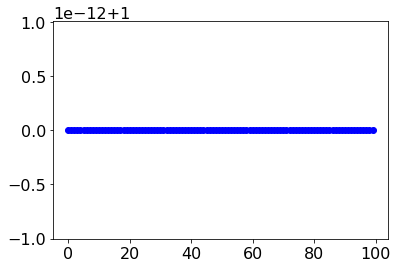

-0.1914564703531091


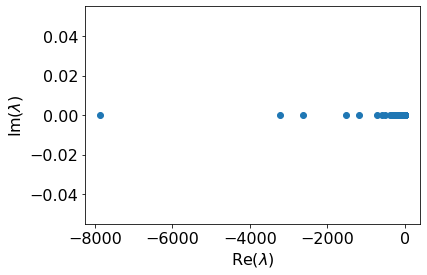

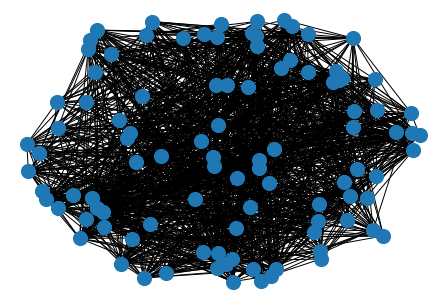

In [461]:
n=100
c=2.0
nr=int(c*n)
seed=31

np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr)
adj=np.zeros((n,n))
for r in range(2*nr):
    reac=np.where(eta[r]>0)[0]
    prod=np.where(nu[r]>0)[0]
    for i in reac:
        for j in prod:
            adj[i,j]=1
        #if species are both reactants, they affect rates of change of each other
        for j in reac:
            adj[i,j]=1
g=nx.convert_matrix.from_numpy_matrix(adj)

lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]

print(n)
X0=np.exp(-G)
XD1=np.zeros(n)
XD2=np.zeros(n)
Xs2=rmtchem.steady(X0,eta,nu,k,XD1,XD2).x
plt.plot(Xs2/X0,'bo')
plt.show()

evals,evecs=np.linalg.eig(rmtchem.jac(X0,eta,nu,k,XD1,XD2))
plt.xlabel('$\mathrm{Re}(\lambda)$')
plt.ylabel('$\mathrm{Im}(\lambda)$')
plt.scatter(x=np.real(evals),y=np.imag(evals))
print(np.max(np.real(evals)))
plt.savefig('plots/fig0b.pdf')
plt.show()
g=nx.from_numpy_matrix(rmtchem.jac(np.exp(-G),eta,nu,k,XD1,XD2))
nx.draw(g,node_size=200)
plt.savefig('plots/fig0a.pdf')
plt.show()
# Xs,success=rmtchem.integrate(X0,eta,nu,k,XD1,XD2,100,0.1,prog=True)
# plt.plot(Xs)
# plt.show()

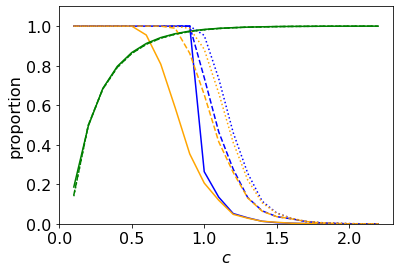

In [460]:
n=200
ns=[100,500,1000]
ls=['-','--',':']
plt.xlabel('$c$')
plt.ylabel("proportion")
plt.ylim(0,1.1)
for i in range(3):
    n=ns[i]
    dat=np.loadtxt('data/sing/'+str(n)+'/scounts.txt')
    plt.plot(dat[:,1],dat[:,2],color='blue',linestyle=ls[i])
    plt.plot(dat[:,1],dat[:,3],color='orange',linestyle=ls[i])
    plt.plot(dat[:,1],dat[:,4]/n,color='green',linestyle=ls[i])
plt.savefig("plots/fig0c.pdf",transparent=True)
plt.show()

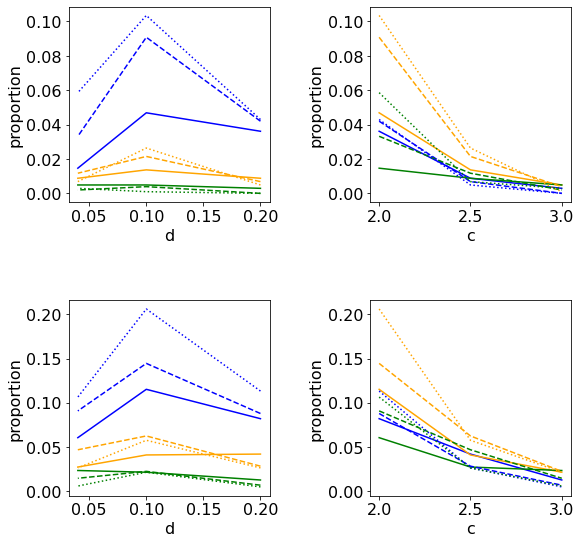

In [32]:
ns=[50,100,200]
ls=["-","--",":"]
cols=["blue","orange","green"]

plt.subplots(2,2,figsize=(9, 9))

plt.subplot(2,2,1)
for nind in range(3):
    n=ns[nind]
    vals=np.loadtxt('data/'+str(n)+'counts.txt')
    cs=np.unique(vals[:,1])
    for cind in range(len(cs)):
        c=cs[cind]
        inds=np.where(vals[:,1]==c)[0]
        order=np.argsort(vals[inds,2])
        plt.plot(1/vals[inds,2][order],vals[inds,6][order],color=cols[cind],linestyle=ls[nind])
plt.ylabel('proportion')
plt.xlabel('d')

plt.subplot(2,2,2)
for nind in range(3):
    n=ns[nind]
    vals=np.loadtxt('data/'+str(n)+'counts.txt')
    ds=np.unique(vals[:,2])
    for cind in range(len(ds)):
        d=ds[cind]
        inds=np.where(vals[:,2]==d)[0]
        order=np.argsort(vals[inds,1])
        plt.plot(vals[inds,1][order],vals[inds,6][order],color=cols[cind],linestyle=ls[nind])
plt.ylabel('proportion')
plt.xlabel('c')

plt.subplot(2,2,3)
for nind in range(3):
    n=ns[nind]
    vals=np.loadtxt('data/'+str(n)+'counts.txt')
    cs=np.unique(vals[:,1])
    for cind in range(len(cs)):
        c=cs[cind]
        inds=np.where(vals[:,1]==c)[0]
        order=np.argsort(vals[inds,2])
        plt.plot(1/vals[inds,2][order],vals[inds,7][order],color=cols[cind],linestyle=ls[nind])
plt.ylabel('proportion')
plt.xlabel('d')

plt.subplot(2,2,4)
for nind in range(3):
    n=ns[nind]
    vals=np.loadtxt('data/'+str(n)+'counts.txt')
    ds=np.unique(vals[:,2])
    for cind in range(len(ds)):
        d=ds[cind]
        inds=np.where(vals[:,2]==d)[0]
        order=np.argsort(vals[inds,1])
        plt.plot(vals[inds,1][order],vals[inds,7][order],color=cols[cind],linestyle=ls[nind])
plt.ylabel('proportion')
plt.xlabel('c')

plt.subplots_adjust(wspace=0.5,hspace=0.5)
plt.savefig('plots/fig1.pdf')
plt.show()

When we introduce small driving in the same network, the steady state is perturbed and some eigenvalues become complex. We can find the steady state with root finding, and the same steady state is found by numerical integration.

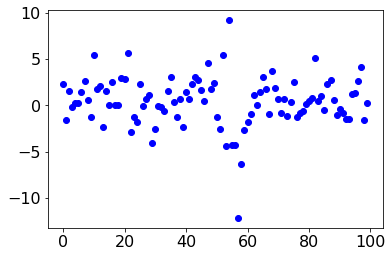

Calculated dynamics in  2.9275454399999994 seconds


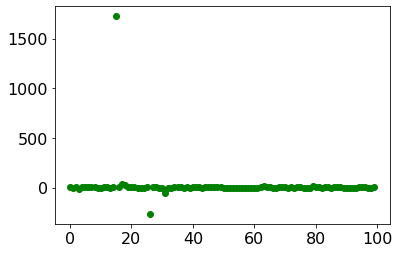

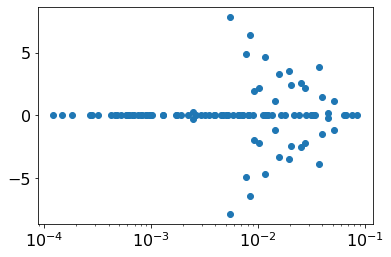

-11.762077182145166


In [3]:
np.random.seed(1)
eta,nu,k,G=rmtchem.get_network(n,nr)

drive0=1e3
drive=3

XD1=np.zeros(n)
XD2=np.zeros(n)
ndrives=10
inds=np.random.choice(range(n),size=ndrives,replace=False)
scales=np.exp(-G[inds])
XD2[inds]=drive0
XD1[inds]=scales*drive*drive0

X0=np.exp(-G)
Xs2=rmtchem.steady(X0,eta,nu,k,XD1,XD2).x
plt.plot(Xs2/X0,'bo')
plt.show()

t1=100
dt=1
start=timeit.default_timer()
Xs3,success=rmtchem.integrate(X0,eta,nu,k,XD1,XD2,t1,dt)
stop=timeit.default_timer()
print("Calculated dynamics in ", stop-start, "seconds")
plt.plot(Xs3[-1]/Xs2,'go')
plt.show()
evals,evecs=np.linalg.eig(rmtchem.jac(Xs3[-1],eta,nu,k,XD1,XD2))
plt.xscale('log')
plt.scatter(x=-1/np.real(evals),y=np.imag(evals))
plt.show()
print(np.max(np.real(evals)))

Adiabatically turning on driving then increasing driving amplitude, track the maximum eigenvalues

Saddle-node for iseed=1 around m=140 with 
inds=np.argsort(np.sum(eta+nu,axis=0))[-ndrives:]
n=100 c=2
seed0=1 numseeds=10 ndrives=3
steps=100 d0min=-1 d0max=3
steps2=200 dmin=1 dmax=20!

TODO: make this an quasistatic function, taking d0min, d0max, d1min, d1max

37.356	42	100	0	0	1



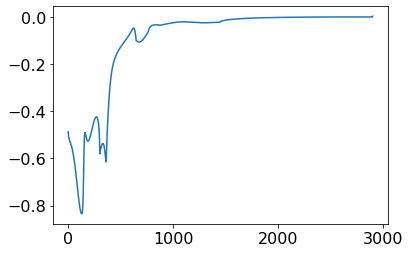

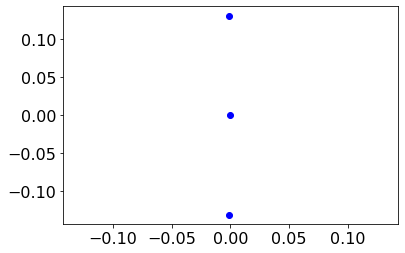

(0.002984074205422239-0.12945997173866902j)
True 8.465572255112636e-11


Integration: 100%|##############################################| Time: 0:00:26


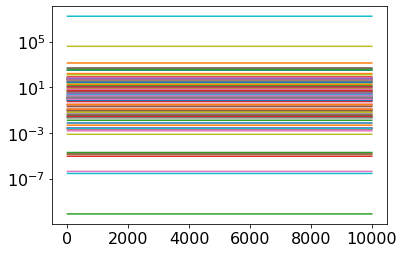

True 8.465572254521535e-11


In [62]:
filebase='data/test'
file=open(filebase+'out.dat','r')
[n,nr,nd,seed,steps,skip,d0,d1max]=np.array(file.readline().split(),dtype=float)
[n,nr,nd,seed,steps,skip]=np.array([n,nr,nd,seed,steps,skip],dtype=int)
print(file.readline())
file.close()
np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr)
d1min=1
d1s=np.arange(d1min,d1max,(d1max-d1min)/steps)
evals=np.load(filebase+'evals.npy')
Xs=np.load(filebase+'Xs.npy')
XD1s=np.zeros((steps,n))
XD2s=np.zeros((steps,n))
# inds=np.argsort(np.exp(-G))[:nd]
inds=np.random.choice(np.arange(n),size=nd,replace=False)
scales=np.exp(-G[inds])
for m in range(steps):
    XD1s[m,inds]=d1s[m]*d0*scales
    XD2s[m,inds]=d0
plt.plot(np.max(np.real(evals),axis=1))
plt.show()
lim=1.1*np.max(np.abs(evals[-1,np.argsort(np.real(evals[-1]))[-3:]]))
plt.xlim(-lim,lim)
plt.ylim(-lim,lim)
plt.plot(np.real(evals[-2]),np.imag(evals[-2]),'bo')
plt.show()
print(evals[-1,np.argsort(np.real(evals[-1]))[-1]])
mmax=len(Xs)
m=mmax-1
X0=Xs[m]
XD1=XD1s[(m)*skip]
XD2=XD2s[(m)*skip]
sol=rmtchem.steady(X0, eta, nu, k, XD1,XD2)
print(sol.success,np.min(sol.x),flush=True)

X2,success=rmtchem.integrate(X0, eta, nu, k, XD1,XD2,1000,0.1,prog=True)
plt.yscale('log')
plt.plot(X2/np.exp(-G))
plt.show()
sol=rmtchem.steady(X2[-1], eta, nu, k, XD1,XD2)
print(sol.success,np.min(sol.x),flush=True)

False -6.90596002938765e-10


Integration: 100%|##############################################| Time: 0:01:09


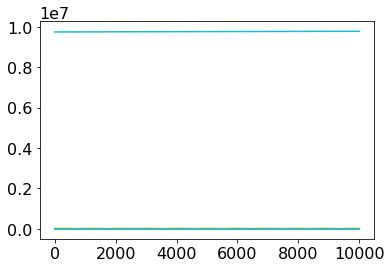

In [66]:
XD1=XD1s[m*skip]*(1.02)
XD2=XD2s[m*skip]
sol=rmtchem.steady(X0, eta, nu, k, XD1,XD2)
print(sol.success,np.min(sol.x),flush=True)
X2,success=rmtchem.integrate(X0, eta, nu, k, XD1,XD2,1000,0.1,prog=True)

plt.yscale('log')
plt.plot(X2)
plt.show()